In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os, sys
sys.path.append('..')
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [10]:
DENSE = False
EPS = 120
LAG = 24 + 1
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [70]:
COMPARE = [
    [
        'single node',
        'checkpoints/mpnn_n1_full.pth',
        [
            "400860-400861"
        ],
        [
            [0, []]
        ]
    ],
    [
        '2neighbors-FCG',
        'checkpoints/mpnn_n3_full.pth',
        [
            "400860-400861",
            "400861-403781",
            "400861-405376"
        ],
        [
            [0, [1, 2]],
            [1, [0]],
            [2, [0]]
        ]
    ]
]
for ti, (_, _, nlist, adjlist) in enumerate(COMPARE):
    adjobj = {}
    for entry in adjlist:
        adjobj[nlist[entry[0]]] = []
        for ai, adjn in enumerate(entry[1]):
            adjobj[nlist[entry[0]]].append(nlist[entry[1][ai]])
    COMPARE[ti][2] = adjobj
MAXSET = COMPARE[1][2] # for fair generation of test examples

In [57]:
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

Full history
 [*] Segments: 90 co-avail
    * [400861-405376]: 90
    * [400861-403781]: 90
    * [400860-400861]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31
Test: single node
 [*] weights: checkpoints/mpnn_n1_full.pth
 [*] Eval segments: 18
 [*] Eval MSE: 0.1033


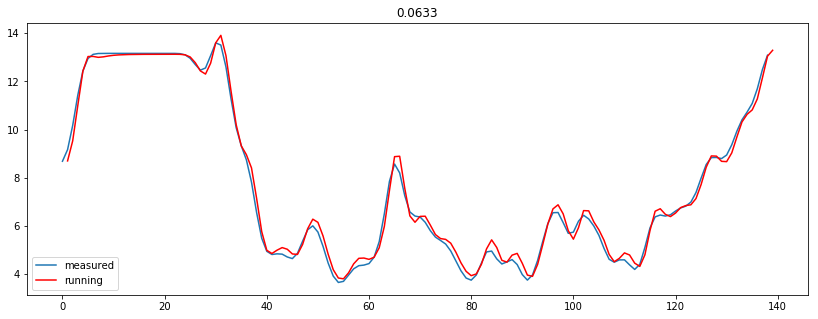

../models/MPRNN.py:100: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  hout, hdn = rnn.rnn(hin, hdn)


Test: 2neighbors-FCG
 [*] weights: checkpoints/mpnn_n3_full.pth
 [*] Eval segments: 18
 [*] Eval MSE: 0.2816


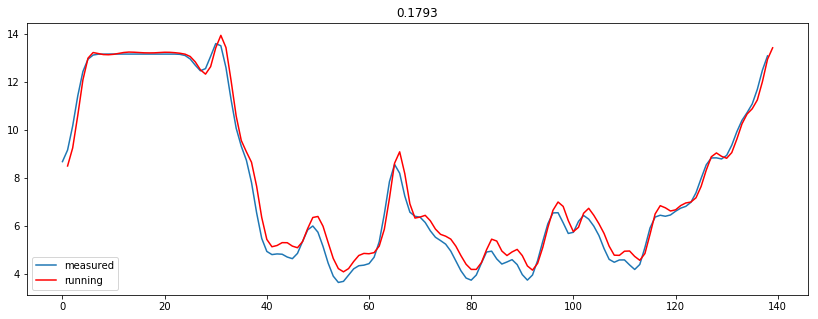

In [73]:
from models.temporal.RNN import *
from models.MPRNN import *
from utils import *
    
viewset = SpotHistory(
        MAXSET, 'test', 16, lag=None, preproc='s', res=10, shuffle=False, verbose=True)

for test_name, ckpt, SROUTE, ADJ in COMPARE:
    model = torch.load('../' + ckpt)
    model.eval()
    
    subset = list(map(lambda series: series[:, :len(SROUTE)], viewset))
    
    sqerr = eval_rnn(subset, model, plot=False, xfmt=xfmt)
    print('Test: %s' % test_name)
    print(' [*] weights:', ckpt)
    print(' [*] Eval segments:', len(viewset))
    print(' [*] Eval MSE: %.4f' % np.mean(sqerr))
    _ = eval_rnn(subset[:1], model, plot=True, xfmt=xfmt)
